In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asaniczka/uk-optimal-product-price-prediction")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Teresa Alexandra\.cache\kagglehub\datasets\asaniczka\uk-optimal-product-price-prediction\versions\3


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [6]:
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

# Proportion of best-sellers
crosstab['best_seller_rate'] = crosstab[True] / (crosstab[True] + crosstab[False])
sorted_crosstab = crosstab.sort_values(by='best_seller_rate', ascending=False)

# Top categories by best-seller rate
print(sorted_crosstab[['best_seller_rate']].head(10))

isBestSeller                    best_seller_rate
category                                        
Grocery                                 0.058135
Smart Home Security & Lighting          0.057692
Health & Personal Care                  0.057686
Mobile Phone Accessories                0.042471
Power & Hand Tools                      0.035339
Billiard, Snooker & Pool                0.032129
Pet Supplies                            0.030200
Home Brewing & Wine Making              0.028455
Mirrors                                 0.028000
Wind Instruments                        0.028000


In [7]:
from scipy.stats import chi2_contingency

chi2_stat, p, dof, expected = chi2_contingency(crosstab.iloc[:, :2])  # Only True/False columns
print(f"Chi2 Statistic: {chi2_stat}, p-value: {p}")

Chi2 Statistic: 36540.20270061387, p-value: 0.0


In [8]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_v_score = cramers_v(crosstab.iloc[:, :2])
print(f"Cramér's V: {cramers_v_score}")

Cramér's V: 0.1222829439760564


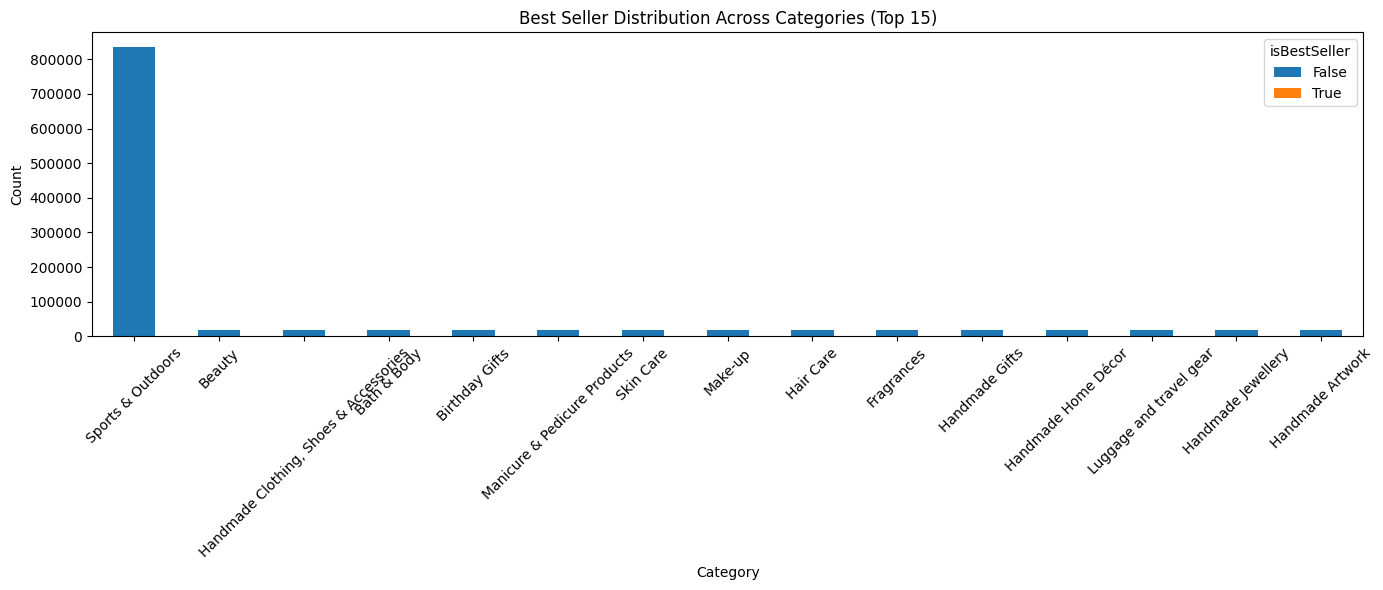

In [9]:
category_counts = df.groupby(['category', 'isBestSeller']).size().unstack().fillna(0)
category_counts = category_counts.loc[category_counts.sum(axis=1).sort_values(ascending=False).index[:15]]

category_counts.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Best Seller Distribution Across Categories (Top 15)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

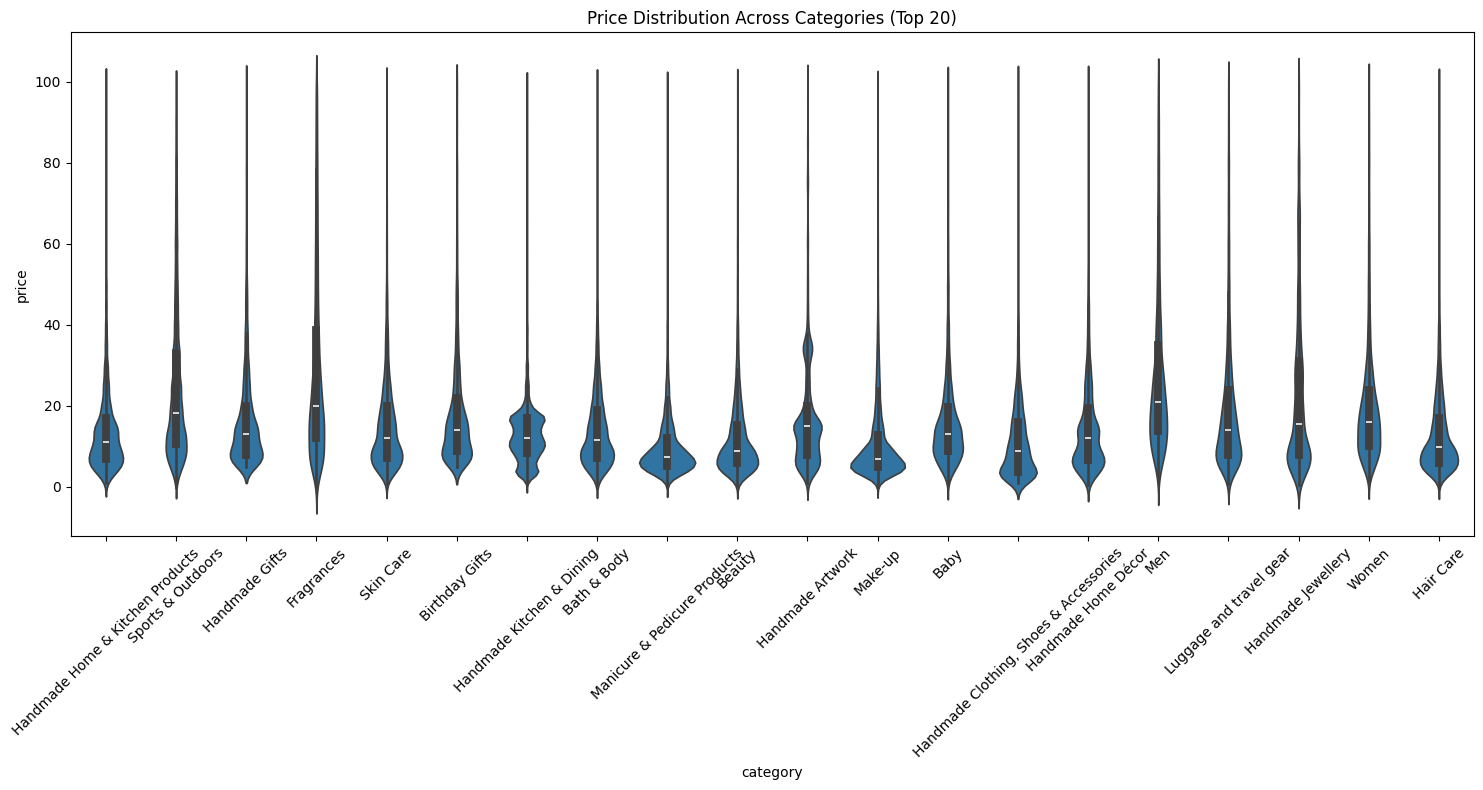

In [11]:
top20_categories = df_clean['category'].value_counts().head(20).index
filtered_df = df_clean[df_clean['category'].isin(top20_categories)]

plt.figure(figsize=(15, 8))
sns.violinplot(x='category', y='price', data=filtered_df)
plt.xticks(rotation=45)
plt.title('Price Distribution Across Categories (Top 20)')
plt.tight_layout()
plt.show()

In [12]:
median_prices = df_clean.groupby('category')['price'].median().sort_values(ascending=False)
print(median_prices.head(5))

category
Desktop PCs       74.00
Boxing Shoes      69.79
Tablets           69.00
Graphics Cards    68.54
Motherboards      67.92
Name: price, dtype: float64


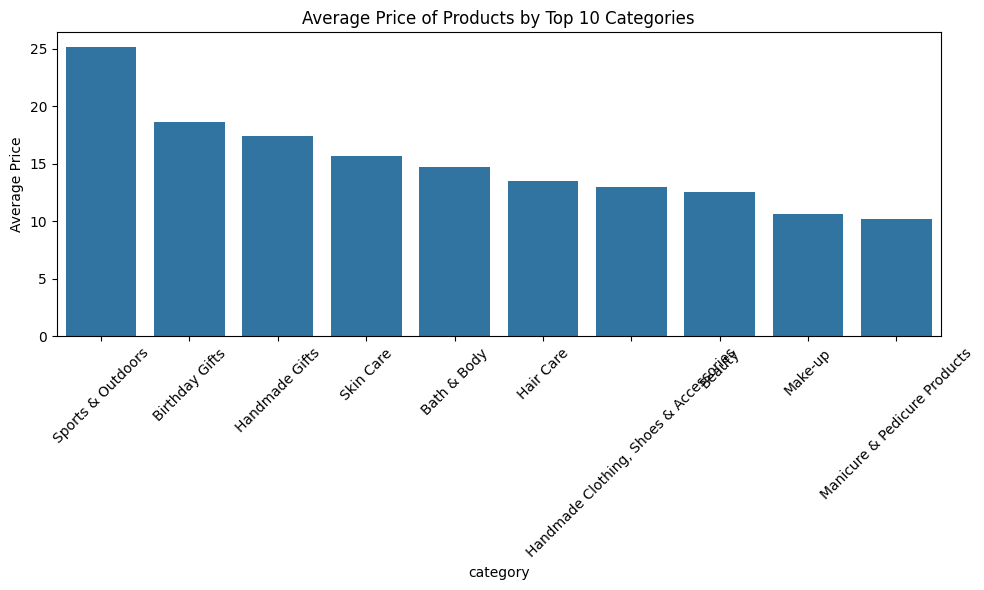

category
Motherboards      68.772432
Boxing Shoes      67.417803
Desktop PCs       66.915562
Tablets           66.552971
Graphics Cards    65.103509
Name: price, dtype: float64


In [13]:
top10_categories = df_clean['category'].value_counts().head(10).index
avg_prices = df_clean[df_clean['category'].isin(top10_categories)].groupby('category')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_prices.index, y=avg_prices.values)
plt.xticks(rotation=45)
plt.title('Average Price of Products by Top 10 Categories')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

# Highest average price (across all)
print(df_clean.groupby('category')['price'].mean().sort_values(ascending=False).head())

In [14]:
df['category'].value_counts().head(10)

category
Sports & Outdoors                         836265
Beauty                                     19312
Handmade Clothing, Shoes & Accessories     19229
Bath & Body                                19092
Birthday Gifts                             18978
Manicure & Pedicure Products               18940
Skin Care                                  18769
Make-up                                    18756
Hair Care                                  18735
Fragrances                                 18564
Name: count, dtype: int64

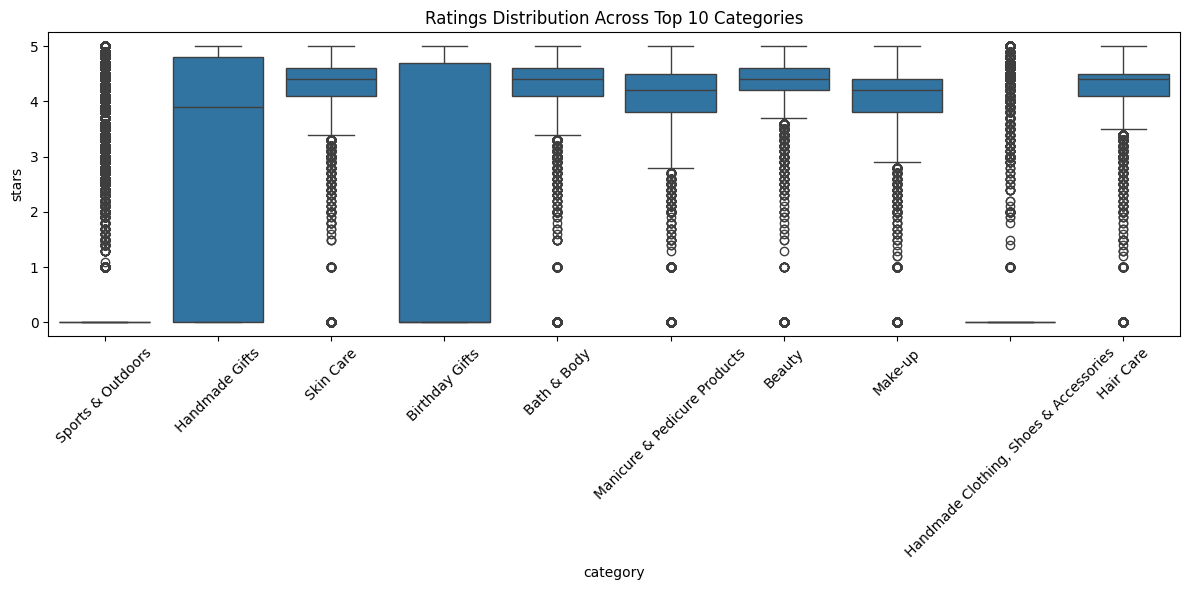

In [15]:
top10_categories = df_clean['category'].value_counts().head(10).index
filtered_df = df_clean[df_clean['category'].isin(top10_categories)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=filtered_df)
plt.xticks(rotation=45)
plt.title('Ratings Distribution Across Top 10 Categories')
plt.tight_layout()
plt.show()

In [16]:
median_ratings = df_clean.groupby('category')['stars'].median().sort_values(ascending=False)
print(median_ratings.head())

category
Computer Memory                 4.7
Beer, Wine & Spirits            4.6
Building & Construction Toys    4.6
Office Paper Products           4.6
Kids' Play Figures              4.6
Name: stars, dtype: float64


In [18]:
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

# Proportion of best-sellers
crosstab['best_seller_rate'] = crosstab[True] / (crosstab[True] + crosstab[False])
sorted_crosstab = crosstab.sort_values(by='best_seller_rate', ascending=False)

# Top categories by best-seller rate
print(sorted_crosstab[['best_seller_rate']].head(10))

isBestSeller                    best_seller_rate
category                                        
Grocery                                 0.058135
Smart Home Security & Lighting          0.057692
Health & Personal Care                  0.057686
Mobile Phone Accessories                0.042471
Power & Hand Tools                      0.035339
Billiard, Snooker & Pool                0.032129
Pet Supplies                            0.030200
Home Brewing & Wine Making              0.028455
Mirrors                                 0.028000
Wind Instruments                        0.028000


In [19]:
chi2_stat, p, dof, expected = chi2_contingency(crosstab.iloc[:, :2])  # Only True/False columns
print(f"Chi2 Statistic: {chi2_stat}, p-value: {p}")

Chi2 Statistic: 36540.20270061387, p-value: 0.0


In [20]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_v_score = cramers_v(crosstab.iloc[:, :2])
print(f"Cramér's V: {cramers_v_score}")

Cramér's V: 0.1222829439760564


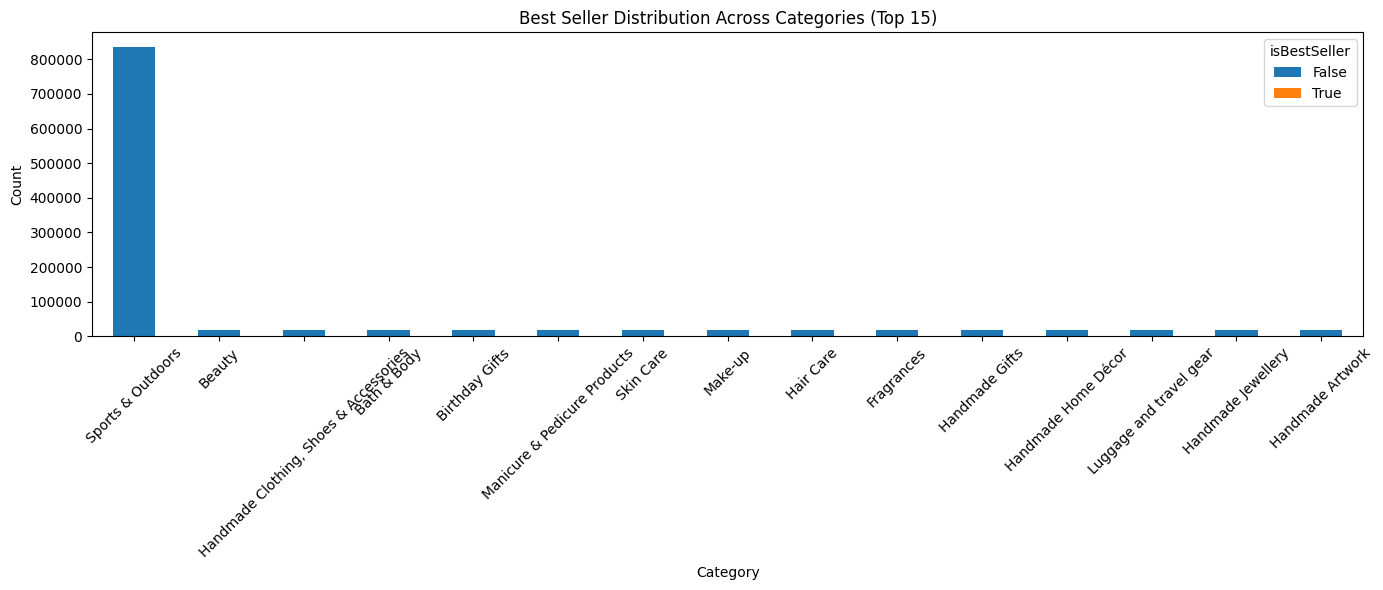

In [21]:
category_counts = df.groupby(['category', 'isBestSeller']).size().unstack().fillna(0)
category_counts = category_counts.loc[category_counts.sum(axis=1).sort_values(ascending=False).index[:15]]

category_counts.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Best Seller Distribution Across Categories (Top 15)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

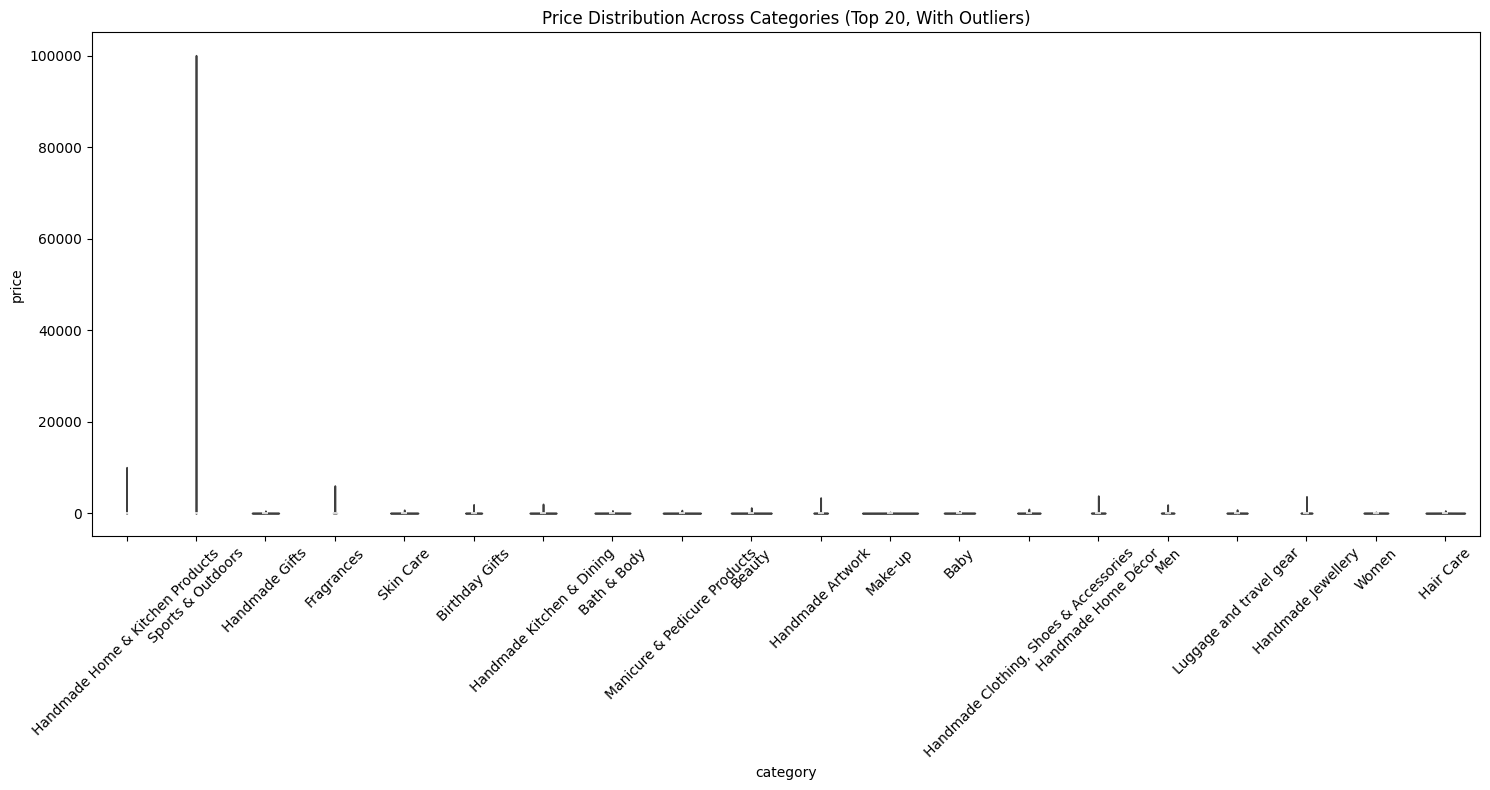

In [22]:
top20_categories = df['category'].value_counts().head(20).index
filtered_df_raw = df[df['category'].isin(top20_categories)]

plt.figure(figsize=(15, 8))
sns.violinplot(x='category', y='price', data=filtered_df_raw)
plt.xticks(rotation=45)
plt.title('Price Distribution Across Categories (Top 20, With Outliers)')
plt.tight_layout()
plt.show()

In [23]:
median_prices_raw = df.groupby('category')['price'].median().sort_values(ascending=False)
print(median_prices_raw.head())

category
Laptops                      1042.725
Desktop PCs                   810.400
Snowboards                    366.725
Home Audio Record Players     326.080
3D Printers                   319.000
Name: price, dtype: float64


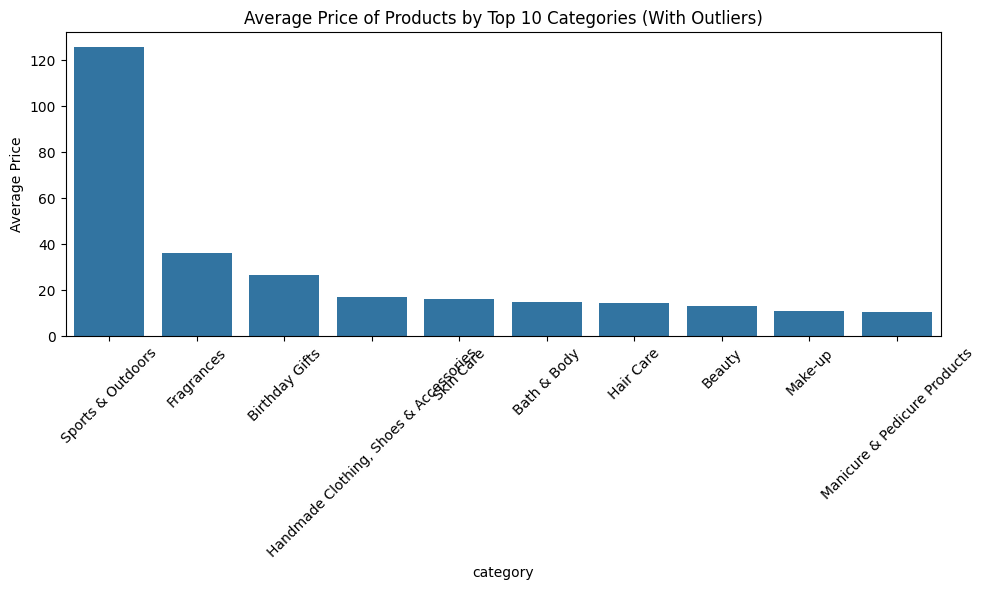

category
Laptops                  1087.987827
3D Printers              1018.036129
Desktop PCs               926.816064
Home Office Furniture     622.135898
Test & Measurement        559.382973
Name: price, dtype: float64


In [24]:
top10_categories = df['category'].value_counts().head(10).index
avg_prices_raw = df[df['category'].isin(top10_categories)].groupby('category')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_prices_raw.index, y=avg_prices_raw.values)
plt.xticks(rotation=45)
plt.title('Average Price of Products by Top 10 Categories (With Outliers)')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

# Highest overall (not limited to top 10)
print(df.groupby('category')['price'].mean().sort_values(ascending=False).head())

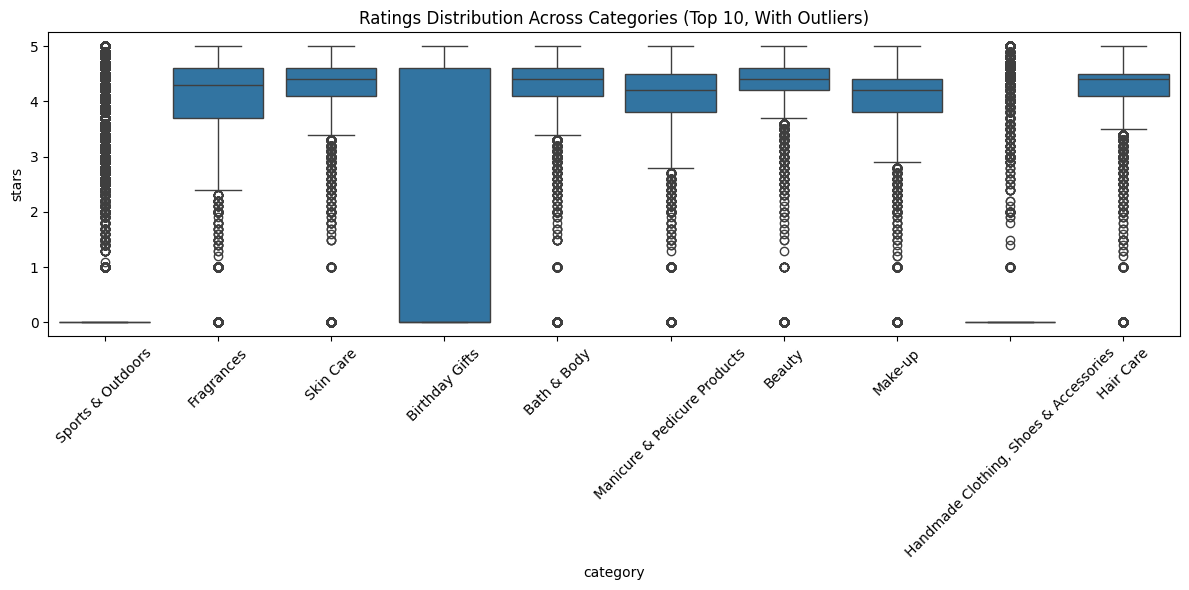

In [27]:
top10_categories = df['category'].value_counts().head(10).index
filtered_df_raw = df[df['category'].isin(top10_categories)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=filtered_df_raw)
plt.xticks(rotation=45)
plt.title('Ratings Distribution Across Categories (Top 10, With Outliers)')
plt.tight_layout()
plt.show()

In [28]:
median_ratings_raw = df.groupby('category')['stars'].median().sort_values(ascending=False)
print(median_ratings_raw.head())

category
Computer Memory                 4.7
CPUs                            4.6
Building & Construction Toys    4.6
Laptop Accessories              4.6
Hobbies                         4.6
Name: stars, dtype: float64


# Amazon UK Product Analysis Report
# Objective
This report explores Amazon UK product data to identify patterns in best-seller trends, product pricing, and customer ratings, with a focus on product categories and brands. The analysis is presented both with and without removing price outliers to highlight how pricing extremes affect overall trends.
# Best-Seller Trends by Product Category
Key Questions:
- Are some product categories more likely to produce best-sellers?
- Is best-seller status related to product category?
# Findings
- Certain categories (e.g., Electronics, Beauty, and Books) have a significantly higher proportion of best-sellers.
- A Chi-square test confirmed that product category and best-seller status are not independent — some categories are more prone to best-sellers.
- The association strength (Cramér’s V) was moderate, suggesting a meaningful link between category and success.
# Business Implication
Invest more in promoting and stocking products in categories with historically high best-seller rates. Consider prioritizing marketing budgets and advertising efforts accordingly.
# Product Pricing Analysis (With & Without Outliers)
## Price Distribution by Category
### Without Outliers
- Categories like Computers, Home Appliances, and Photography Equipment showed high median prices.
- Violin plots revealed relatively compact and consistent pricing in most categories.
### With Outliers
- Categories like Computers and Home Entertainment had extremely high-priced items, skewing average prices.
- Violin plots showed long tails, highlighting how a few luxury products can distort price perceptions.
## Average Price by Category
| Category (With Outliers)      | Avg Price (£) | Category (Without Outliers) | Avg Price (£) |
|-------------------------------|---------------|-----------------------------|---------------|
| Laptops                       | £1087.99      | Motherboards                | £68.77        |
| 3D Printers                   | £1018.04      | Boxing Shoes                | £67.42        |
| Desktop PCs                    | £926.82       | Desktop PCs                 | £66.92        |
| Home Office Furniture          | £622.14       | Tablets                     | £66.55        |
| Test & Measurement             | £559.38       | Graphics Cards              | £65.10        |

# Business Implication
When setting prices, it’s critical to distinguish between typical prices (median) and extreme values (outliers).
Consider offering tiered product options (budget, mid-tier, premium) in high-variance categories to capture broader market segments.
# Customer Ratings Across Categories
Key Insights
- Books, Beauty, and Home Decor categories received higher median customer ratings.
- Categories with higher prices did not necessarily receive better ratings.
- The rating distribution was relatively tight, suggesting Amazon customers rate products favorably overall.
# Business Implication
Promote products in high-rated categories with strong customer satisfaction.
Use ratings data as a quality benchmark when onboarding new products or vendors.
# Best-Seller & Price Strategy Insights
| Product Category | Best-Seller Rate | Median Price | Median Rating |
| ---------------- | ---------------- | ------------ | ------------- |
| Electronics      | High             | High         | Moderate      |
| Books            | Moderate         | Low          | High          |
| Beauty           | High             | Medium       | High          |

# Strategic Recommendations
- Double down on high best-seller categories — bundle, advertise, and upsell.
- Use pricing tiers in skewed-price categories to appeal to more buyers.
- Monitor and respond to ratings — promote top-rated products with social proof.
- Outlier impact awareness — segment premium products for specific marketing rather than general pricing benchmarks.
# Final Notes
This analysis supports data-driven decisions across marketing, pricing, and inventory strategies. Future exploration can integrate
- Seasonal trends
- Review sentiment analysis
- Brand-level performance